<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb2_generate_and_parse_tfrecords.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 2:</small><br/>Generating and Parsing TFRecords</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    Pursuing our journey into data optimization, we will dedicate the following notebook to <em><strong>TFRecord</em></strong>, TensorFlow format to persist entire datasets.
    <br/><br/>
    We will demonstrate how <em>TFRecords</em> files can be created and parsed.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import tensorflow as tf
import numpy as np
import os

## Writing TFRecords

In the book, we introduce how *TFRecord* files can be used to store in one binary archive complete training datasets, to more efficiently reuse and iterate over them afterwards. In the following section, we will demonstrate how `tf.data` and `tf.train` APIs can be used to process a dataset into a _TFRecord_ file.

### Preparing our Dataset

To illustrate this notebook, we will reuse the `rock-paper-scissors` dataset[$^1$](#ref) (kindly provided by [Laurence Moroney](http://laurencemoroney.com)) from `tensorflow-datasets` as example (c.f. Notebook [6-3](../Chapter06/ch6_nb3_improve_image_quality_with_dae.ipynb)):

In [2]:
import tensorflow_datasets as tfds

hands_builder = tfds.builder("rock_paper_scissors")
hands_builder.download_and_prepare()

print(hands_builder.info)

# Instantiating the dataset we will convert into a TFRecord:
hands_dataset = hands_builder.as_dataset(split=tfds.Split.TEST)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=1.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    urls=['http://laurencemoroney.com/rock-paper-scissors-dataset'],
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3)
    },
    total_num_examples=2892,
    splits={
        'test': <tfds.core.SplitInfo num_examples=372>,
        'train': <tfds.core.SplitInfo num_examples=2520>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @ONLINE {rps,
        author = "Laurence Moroney",
        title = "Rock, Paper, Scissors Dataset",
        month = "feb",
        year = "2019",
        url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
        }
        
    """',
    redistribution_info=,
)



For the sake of the demonstration, we will assume we are planning to train several different models for rock/paper/scissors classifition on lower-quality images, e.g., $64 \times 64$ versions. Therefore, we want to prepare a _TFRecord_ file containing all the above dataset, with resized images. 

In [3]:
input_size = (64, 64)

def prepare_sample(sample):
    sample['image'] = tf.image.resize(sample['image'], input_size)
    # The above operation return float values. We cast them back to uint8:
    sample['image'] = tf.cast(sample['image'], tf.uint8)
    return sample

hands_dataset = hands_dataset.map(prepare_sample)
print(hands_dataset)

<MapDataset shapes: {image: (64, 64, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


***Note:*** Remember from the previous [notebook](.ch7_nb1_set_up_efficient_input_pipelines_with_tf_data.ipynb) that such input pipelines can be automatically optimized by TensorFlow (even though we won't really need the performance gain here):

In [5]:
hands_dataset = hands_dataset.prefetch(1)

options = tf.data.Options()
options.experimental_optimization.map_fusion = True
options.experimental_optimization.map_parallelization = True
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_autotune = True
hands_dataset = hands_dataset.with_options(options)

Let us have a quick look at the dataset we want to serialize:

Image labels: ['scissors' 'scissors' 'rock' 'rock' 'scissors']


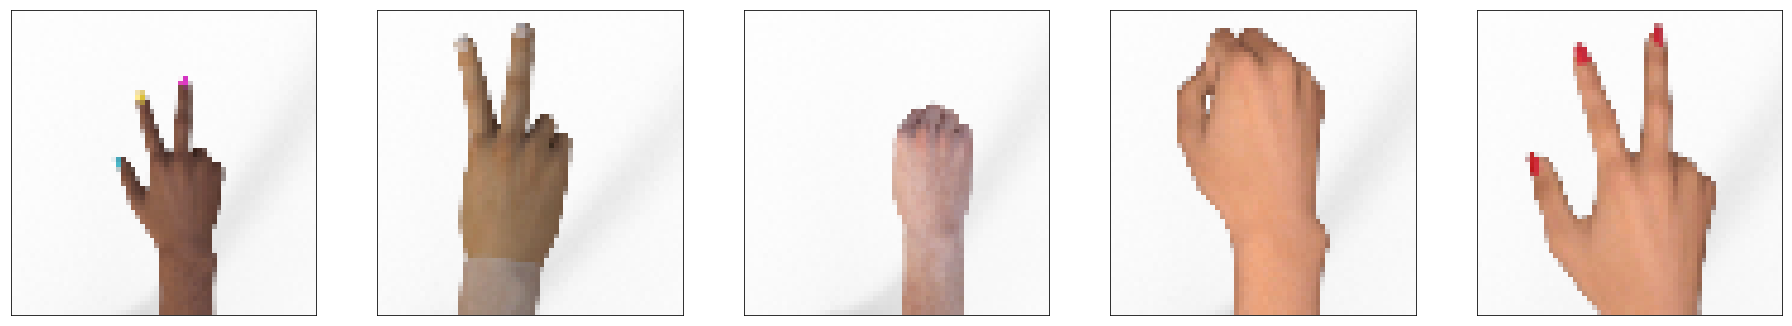

In [8]:
from plot_utils import plot_image_grid
num_show = 5

class_labels = np.asarray(hands_builder.info.features["label"].names)

hands_dataset_iter = hands_dataset.batch(num_show).skip(1).__iter__()
# ^ `.skip(1)` is called to skip the 1st batch, which is a bit "bland" in this dataset.
# We will use the 2nd batch for our illustrations, as it has more diverse hands...
batch = next(hands_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], transpose=True)
fig.show()
print("Image labels: {}".format(class_labels[batch['label'].numpy()]))

### Serializing Data Samples

We presented how TFRecords files are composed of serialized [`tf.train.Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) instances, themselves composed of [`tf.train.Feature`](https://www.tensorflow.org/api_docs/python/tf/train/Feature) objects containing the actual data.

`tf.train.Feature` can contain an element either as a list of double/float values, a list of int/bool values, or a list of bytes. The following functions are usually presented to convert tensors into `Feature` instances:

In [9]:
# Snippet from https://www.tensorflow.org/alpha/tutorials/load_data/tf_records

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

This is all fine, but how can we convert complex data structures like images into `Feature` instances? Well, when stored as JPEG or PNG files, **images are serialized as list of bytes** (compressed or not). We can do the same to transform them into features:

In [10]:
def _image_as_bytes_feature(image):
    """Returns a bytes_list from an image tensor."""
    
    if image.dtype != tf.uint8:
        # `tf.io.encode_jpeg``requires tf.unit8 input images, with values between
        # 0 and 255. We do the conversion with the following function, if needed:
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    
    # We convert the image tensor back into a byte list...
    image_string = tf.io.encode_jpeg(image, quality=90)
    
    # ... and then into a Feature:
    return _bytes_feature(image_string)

A set of `Feature` instances corresponding to one training sample (e.g., an image and its label) can be wrapped into an `Example` object and serialized as follows:

In [11]:
def convert_sample_to_example(sample):
    """ Convert image + label sample into Example for serialization."""
    
    # We convert our elements into serialized features:
    features = tf.train.Features(feature={
        'image': _image_as_bytes_feature(sample['image']),
        'label': _int64_feature(sample['label']),
    })
    
    # Then we wrap them into an Example:
    example = tf.train.Example(features=features)
    return example

This is what a serialized `Example` containing image + label looks like

In [12]:
sample = next(hands_dataset.__iter__())
example = convert_sample_to_example(sample)
print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\003\002\002\003\002\002\003\003\003\003\004\003\003\004\005\010\005\005\004\004\005\n\007\007\006\010\014\n\014\014\013\n\013\013\r\016\022\020\r\016\021\016\013\013\020\026\020\021\023\024\025\025\025\014\017\027\030\026\024\030\022\024\025\024\377\333\000C\001\003\004\004\005\004\005\t\005\005\t\024\r\013\r\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\

To serialize the complete dataset and store it into a TFRecord file, we now only have to iterate over the input pipeline and write the `Example` outputs. To persist them all together according to the TFRecord format, `tf.io.TFRecordWriter` can be used:

In [13]:
tfrecord_file = os.path.join('.', 'resized_rockpaperscissors.tfrecords')

print("Dataset to TFRecords: \033[92mstart\033[0m.")
num_samples = 0
with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for sample in hands_dataset:
        example = convert_sample_to_example(sample)
        writer.write(example.SerializeToString())
        num_samples += 1
print("Dataset to TFRecords: \033[91mend\033[0m ({} examples serialized).".format(num_samples))

Dataset to TFRecords: start.
Dataset to TFRecords: end (372 examples serialized).


This is it, we persisted the integrality of our validation dataset (372 samples) into a TFRecord file (weighing only 570KB)!

## Parsing TFRecords

Now, we will demonstrate how this TFRecord file can be parsed and iterated over with the `tf.data` API.

Instantiating a `tf.data.Dataset` pipeline to iterate over serialized `Example` objects stored in TFRecord file(s) is just a matter of calling the following method:

In [14]:
dataset_from_tfrecord = tf.data.TFRecordDataset(tfrecord_file)

This `Dataset` instance returns serialized `Example` objects. We thus have to parse then. As explained in the book, we need to inform TensorFlow of the structure of the `Example` by defining a dictionary detailing each feature:

In [15]:
def convert_example_to_sample(example):
    """ Parse the serialized example into an image + feature sample."""
    
    # We create a dictionary describing the features.  
    features_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    # We pass the example and descriptive dict to TF parsing function:
    sample =  tf.io.parse_single_example(example, features_description)
    
    # Finally, we decode the sample's JPEG-encoded image string into an actual image:
    sample['image'] = tf.io.decode_jpeg(sample['image'])
    
    return sample

In [16]:
hands_dataset = dataset_from_tfrecord.map(convert_example_to_sample)

Let us make sure we properly parsed the data and recovered our samples: 

Image labels: ['scissors' 'scissors' 'rock' 'rock' 'scissors']


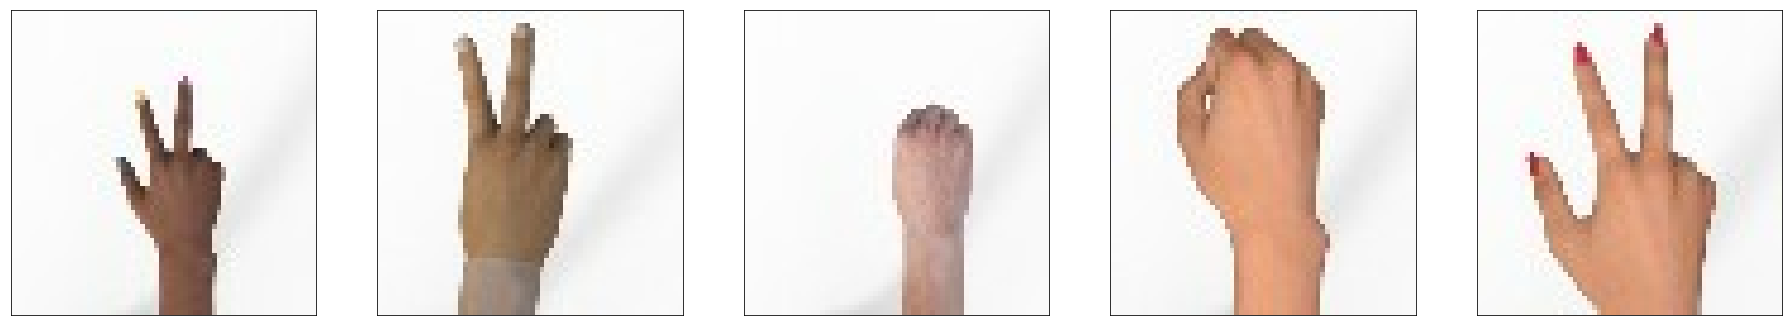

In [17]:
hands_dataset_iter = hands_dataset.batch(num_show).skip(1).__iter__()
# ^ `.skip(1)` is called to skip the 1st batch, which is a bit "bland" in this dataset.
# We will use the 2nd batch for our illustrations, as it has more diverse hands...
batch = next(hands_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], transpose=True)
fig.show()
print("Image labels: {}".format(class_labels[batch['label'].numpy()]))

## Conclusion

With this brief notebook, we presented simple solutions to create and read TFRecord files for applications having to deal with large/fragmented datasets. These files can be especially useful when one wants to persist a specific version of a dataset (e.g., after splitting data between training/validation sets, or after applying some data transformations).

This notebook was the last one specifically dedicated to `tf.data`. In the next [notebook](ch7_nb3_render_images_from_3d_models.ipynb), we will start exploring solutions to train robust models when training data is lacking.

<a id="ref"></a>
#### References

1. Moroney, L., 2019. Rock, Paper, Scissors Dataset. http://laurencemoroney.com/rock-paper-scissors-dataset (Accessed: 03.04.2019).